# Garden monitoring tool
- Computer Vision and Machine learning

## Name: David Mugisha
## REG: 2022/HD05/1765U
## STN NO: 2200701765

## Let us import packages

In [91]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage import io, color, transform
import numpy as np
import os
import cv2
import numpy as np
import glob
from PIL import Image
import os
from PIL import Image
import matplotlib.pyplot as plt
import math

# Extract images from video

### Check the frame rate of the video

In [93]:
# Open the video file.
video = cv2.VideoCapture('garden-video.mp4')

# Get the frames per second (fps) of the video.
fps = video.get(cv2.CAP_PROP_FPS)

print(f"The framerate of the video is {fps} frames per second.")

# Release the video file
video.release()


The framerate of the video is 29.86364416702191 frames per second.


- This Video has a frame rate of proximately 30fps

In [94]:

def extract_frames(video_path, output_folder, frame_rate):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Read the video using OpenCV
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    save_count = 0

    previous_frame = None

    while cap.isOpened():
        # Read the next frame
        ret, frame = cap.read()

        if not ret:
            break

        # Convert the frame from BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if frame_count % frame_rate == 0:
            # Save the frame
            output_path = os.path.join(output_folder, f"frame_{save_count}.jpg")
            cv2.imwrite(output_path, frame)
            save_count += 1

#         if previous_frame is not None and calculate_similarity(previous_frame, rgb_frame):
#             # Skip similar frames
#             continue

        previous_frame = rgb_frame.copy()

        frame_count += 1

    cap.release()

    print(f"Frames extracted: {save_count}")

- This video produces 30 Frames per second.
- When capturing we can consider skipping 30 frames to eliminate so many duplicate frames

In [4]:

# Example usage:
video_path = "garden-video.mp4"
output_folder = "processing-photos"
frame_rate = 30
extract_frames(video_path, output_folder, frame_rate)


# Apply Some noise reduction from images

## Remove non green objects and apply GaussianBlur.
- Remove non green object from images, since our major focus will be on leaves.
- Apply GaussianBlur

In [6]:
# Set the directory you want to start from
rootDir = 'processing-photos'

# Create a new directory to save the green images
os.makedirs('processing-photos/denoised', exist_ok=True)

# # Define the range of green color in HSV
# lower_green = np.array([35, 43, 46])
# upper_green = np.array([77, 255, 255])

# Define a wider range of green color in HSV
lower_green = np.array([27, 25, 25])
upper_green = np.array([100, 255, 255])


# Read all the jpg images in the folder
for file in glob.glob(rootDir + '/*.jpg'):
    # Read the image
    img = cv2.imread(file)
    
    # Apply Gaussian blur
    img = cv2.GaussianBlur(img, (9, 9), 0)
    
    # Convert the image from BGR to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define a kernel for the morphological operations
    kernel = np.ones((5,5), np.uint8)

    # Create a binary mask where green pixels are white and the rest are black
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Apply morphological operations
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img, img, mask=mask)
    
    # Save the image to the new directory
    cv2.imwrite('processing-photos/denoised/' + os.path.basename(file), res)


- The above code removes any object or section in the image that may not be green and saves the new images in the directory provided.

## Group Images According to similarity

- This script uses the ResNet50 model, pre-trained on ImageNet, to classify the images. Each image is loaded and preprocessed to match the input expected by the ResNet50 model, then the model predicts the class of the image. The top prediction is then used to create a new subfolder (if it doesn't already exist), and the image is moved into that subfolder.

- Please adjust the paths in the code to match your local machine settings.

- Remember, this is a simple implementation and doesn't take into account the many edge cases you might encounter in a real-world scenario. For example, ImageNet might not have all the plant classes you have in your folder, or there might be some images that can't be processed correctly, and so on. You'll likely need to refine this code to suit your specific needs.

- This script also assumes that all images are either in the .jpg or .png format. If you have images in other formats, you'll need to adjust the code accordingly.

- Keep in mind, manipulating files on your file system can be risky, so always back up your data before running scripts like this. Also, you should make sure to handle exceptions in your code so that it doesn't crash in case of any unforeseen errors.






## Group the images only in 5 categories

In [7]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.cluster import AgglomerativeClustering
from shutil import move #You can use 'copy' if you want to keep the original

# Load the ResNet50 model with the final dense layer removed.
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to extract features from an image
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features[0]

# Define path to the dump folder
folder_path = 'processing-photos/denoised'

# Extract features for all images in the dump folder
image_features = {}
for img_name in os.listdir(folder_path):
    if not img_name.startswith('.'):  # ignore hidden files
        img_path = os.path.join(folder_path, img_name)
        image_features[img_name] = extract_features(img_path)

# Convert dictionary to list for use with scikit-learn
feature_list = list(image_features.values())
img_name_list = list(image_features.keys())

# Cluster the images using Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters=5)
labels = ac.fit_predict(feature_list)

# Create subfolders within the dump folder for the clusters
for cluster_id in set(labels):
    cluster_folder = os.path.join(folder_path, f'cluster_{cluster_id}')
    os.makedirs(cluster_folder, exist_ok=True)

# Copy images to their respective cluster folders
for img_name, cluster_id in zip(img_name_list, labels):
    move(os.path.join(folder_path, img_name), os.path.join(folder_path, f'cluster_{cluster_id}', img_name))


- First, we need to pre-process the images and extract features using the RESNET50 model. The output from this will be a vector of features for each image, which can then be used to calculate the similarity between images.
- This code uses Agglomerative Clustering, an alternative to K-means that works well for grouping image features. It creates clusters based on similarity of features in a hierarchical manner.

- You can tweak the number of clusters in the AgglomerativeClustering function if you want to create more or less than 4 folders.

- This script will create directories named 'cluster_0', 'cluster_1', etc., in the same directory where the script is running, and copy the images into these directories based on their assigned cluster.

- In the above example, we used the ResNet50 model for feature extraction and KMeans for clustering. Depending on the complexity and variety of your images, you might want to use a different pre-trained model for feature extraction or a different clustering algorithm.

- Also remember to replace '/path_to_images' with the path to your image directory.

- Please note that running this script might take some time depending on the number of images as it processes each image to extract features and then performs clustering.

- Import that dataset

In [88]:
# Path to the dataset
dataset_path = 'processing-photos/denoised'
image_size = 100  # size to resize images to
# n_neighbors = 3  # Number of neighbors for kNN
categories = ['cassava', 'maize', 'banana']

## Let us have a look at the dataset.
 - After Removing non green objects and appling GaussianBlur.

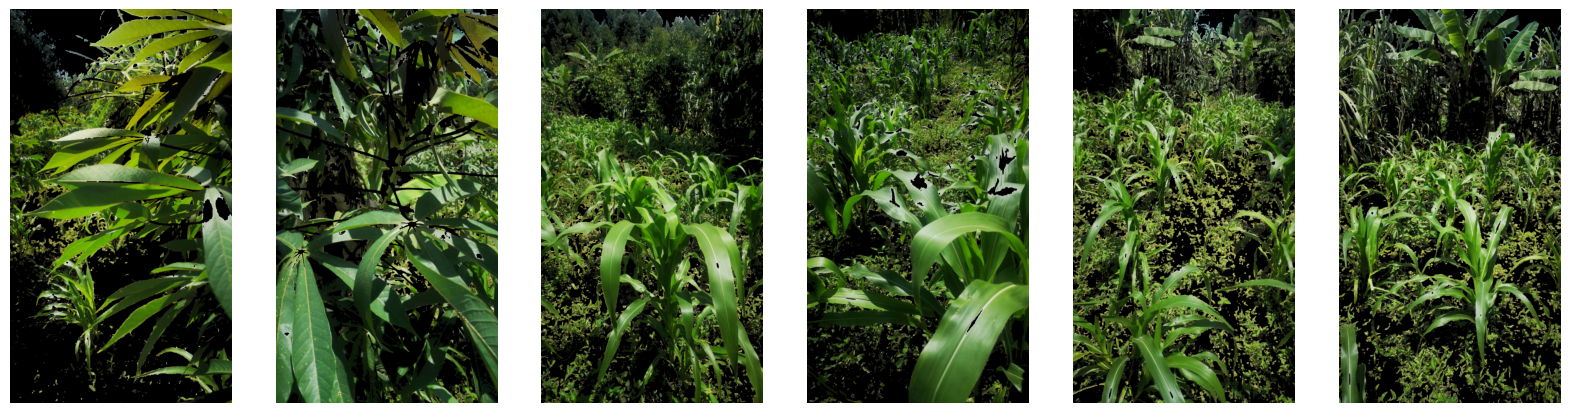

In [89]:
# Define directories for each category
dir1 = dataset_path + "/cassava"
dir2 = dataset_path + "/maize"
dir3 = dataset_path + "/banana"

# Define a function to check if the file is an image
def is_image(filename):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    ext = os.path.splitext(filename)[1]
    return ext.lower() in valid_extensions

# Load images from each category
images1 = [Image.open(os.path.join(dir1, img)) for img in os.listdir(dir1) if is_image(img)][:2]
images2 = [Image.open(os.path.join(dir2, img)) for img in os.listdir(dir2) if is_image(img)][:2]
images3 = [Image.open(os.path.join(dir3, img)) for img in os.listdir(dir3) if is_image(img)][:2]

# Combine all images
all_images = images1 + images2 + images3

# Define grid size
cols = 6  # Number of columns
rows = math.ceil(len(all_images) / cols)  # Number of rows based on the number of images and desired columns

plt.figure(figsize=(20, 20))

# Plot each image in a grid
for i, img in enumerate(all_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.show()


# Cleaning of the image dataset

## Resize the images

In [ ]:
input_folder = 'processing-photos/denoised'  # Path to the original dataset
output_folder = 'processing-photos/annotated'  # Path to the output folder
image_size = (224, 224)  # Desired image size

extensions = ['.jpg', '.png', '.jpeg']  # Add or remove file extensions as needed

for class_folder in os.listdir(input_folder):
    if class_folder == ".DS_Store":  # ignore .DS_Store files
        continue
    input_class_folder = os.path.join(input_folder, class_folder)
    output_class_folder = os.path.join(output_folder, class_folder)
    os.makedirs(output_class_folder, exist_ok=True)  # Create output class folder
    
    if os.path.isdir(input_class_folder):
        for image_name in os.listdir(input_class_folder):
            if image_name == ".DS_Store":  # ignore .DS_Store files
                continue
            if os.path.splitext(image_name)[1].lower() in extensions:
                # Open the image file
                img = Image.open(os.path.join(input_class_folder, image_name))
                # Resize the image
                img_resized = img.resize(image_size, Image.ANTIALIAS)
                # Save the resized image to the output folder
                img_resized.save(os.path.join(output_class_folder, image_name))

print("Resizing completed.")

## Feature Extraction
- Color Histograms
- Texture Features
- Shape Features
- Leaf Features
- Edges
- SIFT
- SURF
- Pixel Values

In [10]:
# handle varing length
def compute_statistics(feature):
    # If there are no features, return an array of zeros
    if feature is None or len(feature) == 0:
        return np.zeros(5)

    # Compute the mean, standard deviation, min, max, and median of the descriptors
    mean = np.mean(feature)
    std = np.std(feature)
    min_val = np.min(feature)
    max_val = np.max(feature)
    median_val = np.median(feature)

    return np.array([mean, std, min_val, max_val, median_val])


In [19]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage import feature, morphology
from matplotlib import pyplot as plt
import shutil

# define input and output directories
# input_dir = "cleaned-images/annotated"
# output_dir = "cleaned-images/features"

# function to extract color histogram
def color_hist(img):
#     hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    if len(img.shape) == 2:  # Grayscale image, no color
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    else:  # Color image
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])

    return hist.flatten()

# function to extract texture features
def texture_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    textures = feature.local_binary_pattern(gray, 8 * 3, 3, method="uniform")
    return textures.flatten()

# function to extract shape features
def shape_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
    contours,_ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    return np.array(areas)

# function to extract edges
def edge_detection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,50,150)
    return edges.flatten()

# function to extract SIFT
def sift_features(img):
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, des = sift.detectAndCompute(gray,None)
    return des.flatten()

# function to extract ORB
def orb_features(img):
    orb = cv2.ORB_create()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, des = orb.detectAndCompute(gray, None)
    if des is not None:
        return des.flatten()
    else:
        return np.array([])

# function to extract pixel values
def pixel_values(img):
    return img.flatten()

# read all images and extract features
def extract_features(img_dir):
    features = []
    labels = []
    for foldername in os.listdir(img_dir):
        subfolder = os.path.join(img_dir, foldername)
        if os.path.isdir(subfolder):  # Make sure subfolder is a directory
            for filename in os.listdir(subfolder):
                file_path = os.path.join(subfolder, filename)
                img = cv2.imread(file_path)
#             original_image = compute_statistics(preprocess_original_image(img))
                color_hist_features = compute_statistics(color_hist(img))
                texture = compute_statistics(texture_features(img))
                shape = compute_statistics(shape_features(img))
                edges = compute_statistics(edge_detection(img))
                sift = compute_statistics(sift_features(img))
                orb = compute_statistics(orb_features(img))
                pixel_val = compute_statistics(pixel_values(img))

                features.append([ color_hist_features, texture, shape, edges, sift, orb, pixel_val])
                labels.append(foldername)
            
             # save the edges image to another folder
#             edge_image_path = os.path.join(output_dir, foldername, filename)
#             if not os.path.exists(os.path.join(output_dir, foldername)):
#                 os.makedirs(os.path.join(output_dir, foldername))
#             edges_img = edges.reshape(img.shape[0], img.shape[1])
#             cv2.imwrite(edge_image_path, edges_img)
    return features,labels


In [20]:
input_dir = "processing-photos/annotated"
# Save the extracted features into a pandas dataframe
final_features, final_labels = extract_features(input_dir)
features_data = pd.DataFrame(final_features, columns=['color_histogram', 'texture_features', 'shape_features', 'edges', 'sift', 'orb', 'pixel_values'])
# features_data.to_csv('plants_features.csv', index=False)

## Let us flatten the features and labels.

In [21]:
labels_flattened = np.array(final_labels)
features_flattened = np.array(final_features).reshape(len(final_features), -1)

In [30]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_flattened, 
                                                                        labels_flattened, 
                                                                        test_size=0.3, 
                                                                        random_state=42)

#  Train Naive Bayes Model

In [31]:
from sklearn.naive_bayes import GaussianNB

# Initialize and train the Gaussian Naive Bayes model
mlNB = GaussianNB()
mlNB.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = mlNB.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
# print('Confusion Matrix:\n', confusion_matrix(labels_test, gnb_labels_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.84375
Classification Report:
               precision    recall  f1-score   support

      banana       0.88      0.78      0.82         9
     cassava       0.92      0.85      0.88        13
       maize       0.75      0.90      0.82        10

    accuracy                           0.84        32
   macro avg       0.85      0.84      0.84        32
weighted avg       0.85      0.84      0.84        32



## Confusion Metrics

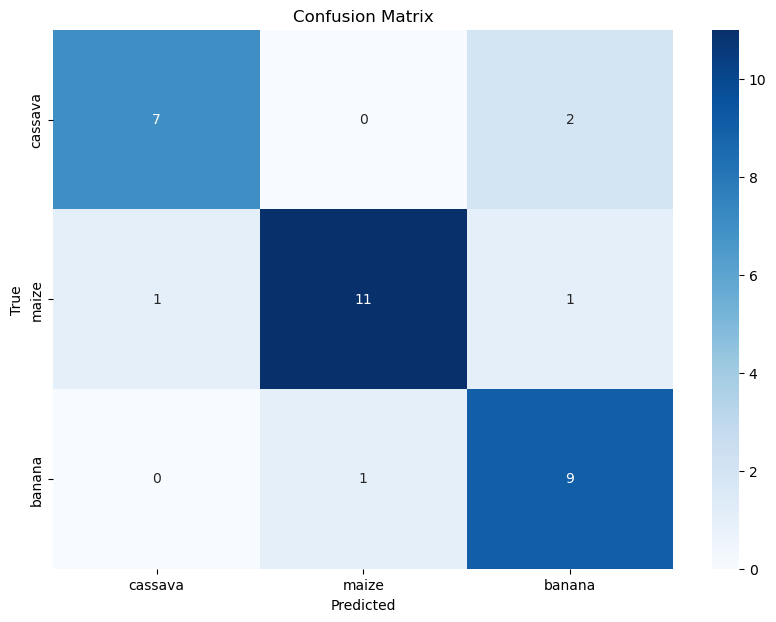

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix in a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Train CNN Model

In [66]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner import RandomSearch

img_height, img_width = 150, 150  # you might need to adjust these depending on your specific images
batch_size = 32  # you might need to adjust this depending on your system's capabilities
data_dir = "processing-photos/annotated"  # replace with the path to your dataset
num_classes = 3  # number of classes in your dataset


/var/folders/pr/mhw6496j40q1jmcvb9sjv9hc0000gn/T/ipykernel_89847/1562533970.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [69]:
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)  # rescale pixel values and set aside 20% of the data for validation

train_generator = datagen.flow_from_directory(data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', subset='training')
validation_generator = datagen.flow_from_directory(data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', subset='validation')

Found 84 images belonging to 3 classes.
Found 21 images belonging to 3 classes.


In [70]:
def build_model(hp):
    model = keras.Sequential()

    # Define hyperparameters for the number of 
    #convolutional layers, their size, and the
    #number of nodes in the dense layer
    # choose a number between 1 and 3
    for i in range(hp.Int("conv_layers", 
                          1, 3)): 
         # choose the number of units from [32, 64, 128]
        model.add(layers.Conv2D(
            hp.Choice(f"conv_{i}_units",
                      [32, 64, 128]), 3, 
            activation='relu'))  
        model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Flatten())
    # choose the number of units from 32 to 512 with step 32
    model.add(layers.Dense(
        units=hp.Int('dense_units', 
                     min_value=32, 
                     max_value=512, 
                     step=32), 
        activation='relu'))  
    model.add(layers.Dense(num_classes, 
                           activation='softmax'))
     # choose the learning rate from 
    #[0.01, 0.001, 0.0001]
    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate',
                  [1e-2, 1e-3, 1e-4])), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [71]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # adjust this depending on how long you want to search
    executions_per_trial=2,  # adjust this depending on how reliable you want the results to be
    directory='output',
    project_name='CNN_hyperparameter_tuning')

tuner.search_space_summary()

tuner.search(train_generator, validation_data=validation_generator, epochs=10)  # adjust the number of epochs depending on your specific needs

tuner.results_summary()

Trial 10 Complete [00h 00m 36s]
val_accuracy: 0.3333333432674408

Best val_accuracy So Far: 0.7142857313156128
Total elapsed time: 00h 07m 24s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in output/CNN_hyperparameter_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
conv_layers: 1
conv_0_units: 128
dense_units: 384
learning_rate: 0.001
conv_1_units: 128
Score: 0.7142857313156128

Trial 06 summary
Hyperparameters:
conv_layers: 1
conv_0_units: 32
dense_units: 384
learning_rate: 0.0001
conv_1_units: 64
Score: 0.642857164144516

Trial 04 summary
Hyperparameters:
conv_layers: 2
conv_0_units: 32
dense_units: 512
learning_rate: 0.01
conv_1_units: 128
Score: 0.5238095372915268

Trial 05 summary
Hyperparameters:
conv_layers: 1
conv_0_units: 128
dense_units: 128
learning_rate: 0.0001
conv_1_units: 128
Score: 0.5000000149011612

Trial 00 summary
Hyperparameters:
conv_layers: 1
conv_0_units: 128
dense_units: 32
learnin

In [78]:
import tensorflow as tf

# Set log level to only show errors
tf.get_logger().setLevel('ERROR')

In [79]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is {best_hyperparameters.get('dense_units')} and the optimal learning rate for the optimizer is {best_hyperparameters.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is 384 and the optimal learning rate for the optimizer is 0.001.



In [84]:
# Assuming you have a test_dir for the test images
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    'processing-photos/annotated',  # directory for the test set
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # important to keep in order, so predictions align with true labels
)

# Generate predictions
predictions = best_model.predict(test_generator, verbose=1)

# Convert one-hot encoded predictions and labels to integers
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

from sklearn.metrics import classification_report

# Calculate the classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

print(report)


Found 105 images belonging to 3 classes.
4/4 [==============================] - 1s 167ms/step
              precision    recall  f1-score   support

      banana       0.90      1.00      0.95        35
     cassava       1.00      0.83      0.91        35
       maize       0.95      1.00      0.97        35

    accuracy                           0.94       105
   macro avg       0.95      0.94      0.94       105
weighted avg       0.95      0.94      0.94       105



### The Confussion Metrics

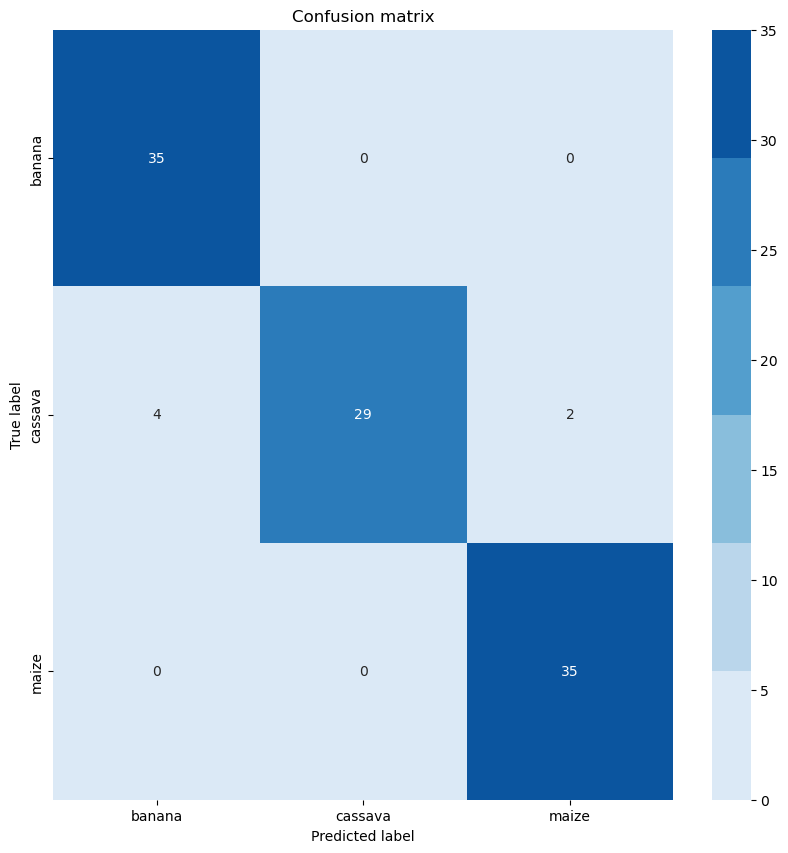

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_generator.class_indices, 
            yticklabels=test_generator.class_indices,
            cmap=sns.color_palette("Blues"))
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()